In [2]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from itertools import compress

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize


# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

In [3]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [4]:
with open(ospj(prodatapath,'bad_ch_dict.pkl'),'rb') as f:
    bad_chs = pickle.load(f)
bad_chs

{'CHOP005': {'LA01',
  'LA02',
  'LA09',
  'LB06',
  'LC01',
  'LC16',
  'LD07',
  'LD09',
  'LD13',
  'LD14',
  'LF08',
  'LF10',
  'LG09',
  'LI03',
  'LI05',
  'LI15',
  'LJ01',
  'LJ12',
  'LL01',
  'LL02',
  'LL13',
  'LM06',
  'LM07',
  'LN14'},
 'CHOP010': set(),
 'CHOP024': {'LA01',
  'LA02',
  'LA03',
  'LA04',
  'LA05',
  'LA06',
  'LA07',
  'LA08',
  'LA09',
  'LA10',
  'LB01',
  'LB02',
  'LB03',
  'LB04',
  'LB05',
  'LB06',
  'LB07',
  'LB08',
  'LB09',
  'LB10',
  'LC01',
  'LC02',
  'LC03',
  'LC04',
  'LC05',
  'LC06',
  'LC07',
  'LC08',
  'LC09',
  'LC10',
  'LC11',
  'LC12',
  'LC13',
  'LC14',
  'LC15',
  'LC16',
  'LD01',
  'LD02',
  'LD03',
  'LD04',
  'LD05',
  'LD06',
  'LD07',
  'LD08',
  'LE01',
  'LE02',
  'LE03',
  'LE04',
  'LE05',
  'LE06',
  'LE07',
  'LE08',
  'LE09',
  'LE10',
  'LE11',
  'LE12',
  'LF01',
  'LF02',
  'LF03',
  'LF04',
  'LF05',
  'LF06',
  'LF07',
  'LF08',
  'LF09',
  'LF10',
  'LF11',
  'LF12',
  'LG01',
  'LG02',
  'LG03',
  'LG04'

## Stimulation Interpolation

### Loading seizures

In [5]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))

In [6]:
pt = 'HUP235'

In [7]:
# Loading data from bids
inter,fs = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
electrode_localizations = pd.read_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
electrode_regions = pd.read_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter = inter.loc[:,neural_channels]

# Detecting and removing excess noisy channels
# mask,_ = detect_bad_channels(inter.to_numpy(),fs)
# inter = inter.drop(inter.columns[~mask],axis=1)
# inter,fs,mask = preprocess_for_detection(inter,fs,wavenet=False)

In [8]:
baseline_stds = inter.std().to_numpy()

(<Figure size 1999.93x1560 with 1 Axes>, <Axes: xlabel='Time (s)'>)

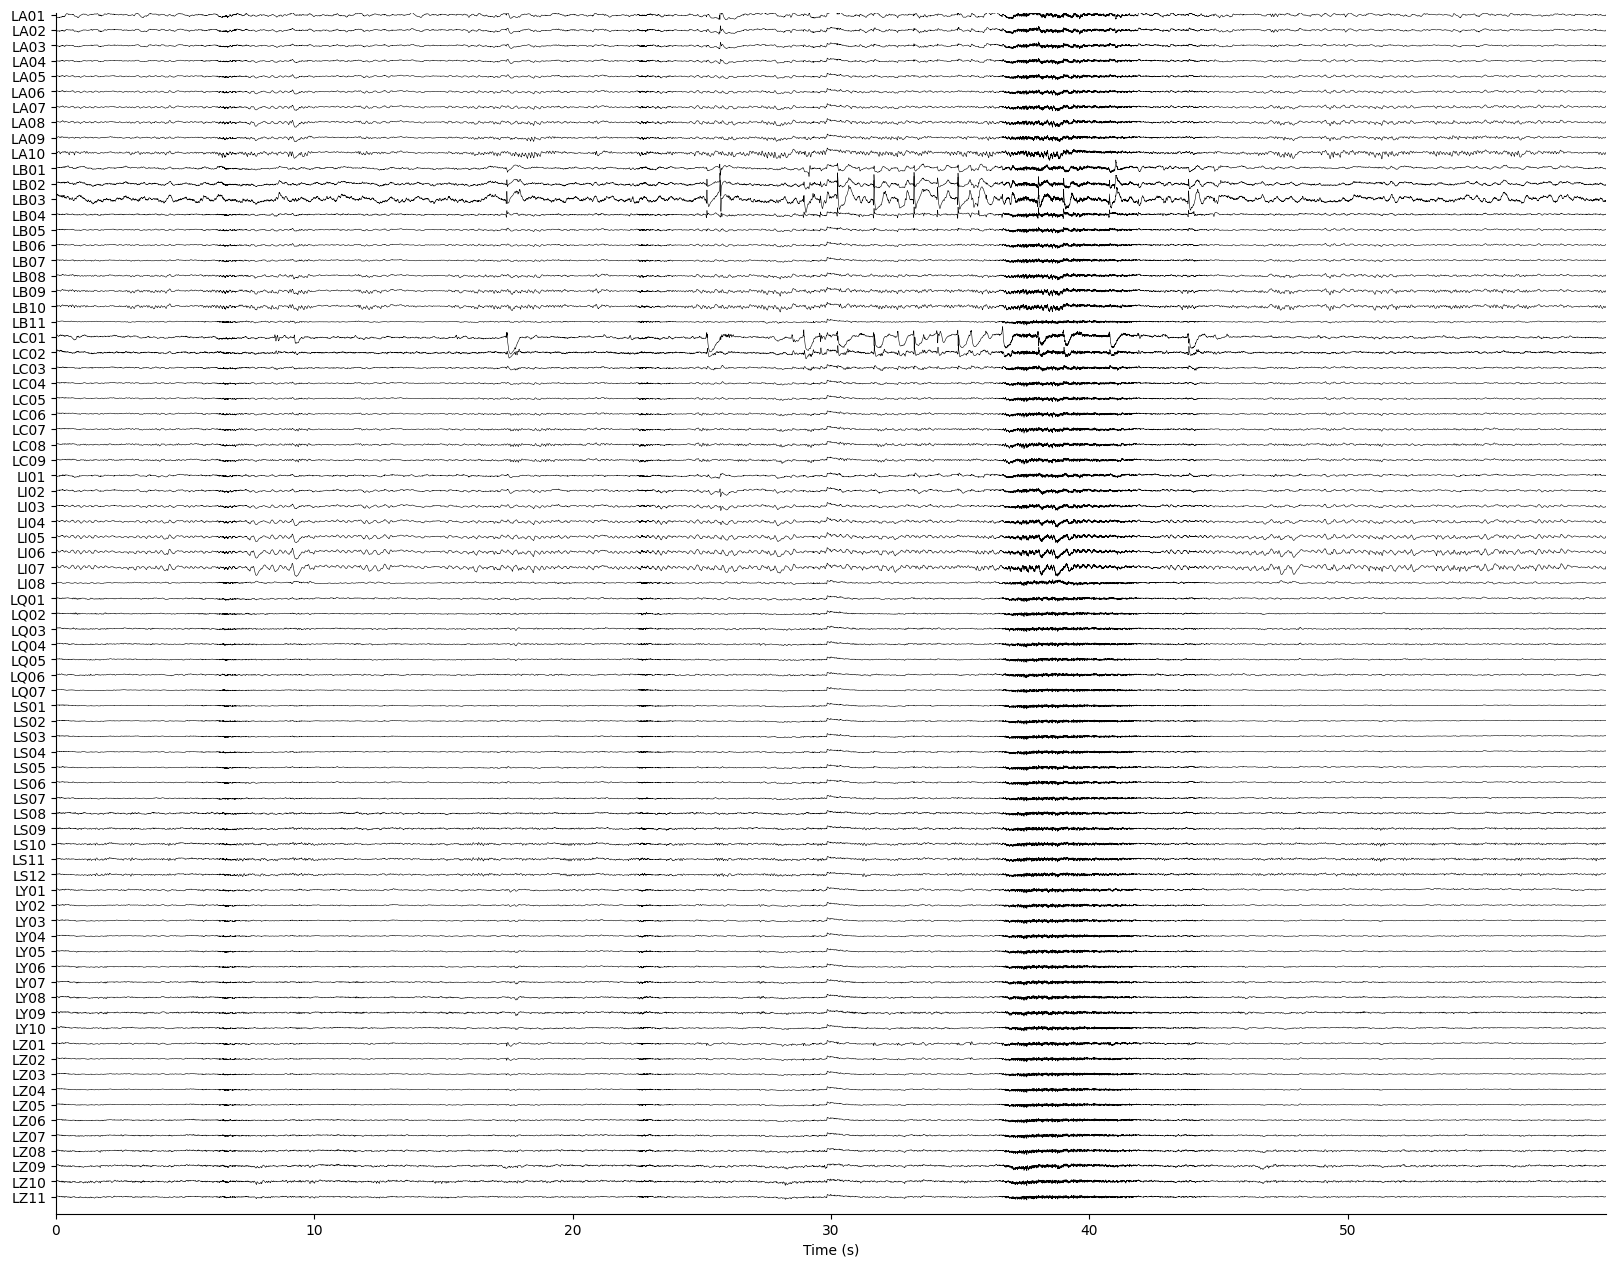

In [9]:
plot_iEEG_data(inter,np.arange(len(inter))/fs)

In [10]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <= -1:
        continue
    # Load in seizure and metadata for BIDS path
    stim_seizure,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    # Filter out bad channels from interictal clip
    stim_seizure = stim_seizure[neural_channels]
    # seizure,fs = preprocess_for_detection(seizure,fs_raw,pre_mask=mask)
    break

In [11]:
stim_ch_mask = np.zeros((len(stim_seizure.columns),),dtype=bool)
for ch in sz_row.stim_channels.split('-'):
    # print(clean_labels([ch],pt))
    ch = clean_labels([ch],pt)[0]
    stim_ch_mask += np.array([ch == c for c in stim_seizure.columns])

In [12]:
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i != 3:
        continue
    # Load in seizure and metadata for BIDS path
    spont_seizure,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    # Filter out bad channels from interictal clip
    spont_seizure = spont_seizure[neural_channels]
    # seizure,fs = preprocess_for_detection(seizure,fs_raw,pre_mask=mask)
    break

### Peak detection

In [13]:
clip = stim_seizure.loc[30*fs_raw:80*fs_raw,stim_ch_mask]

In [14]:
pks,heights = sc.signal.find_peaks(np.abs(np.diff(clip.to_numpy()[:,1])),
                                   height=baseline_stds[stim_ch_mask][1]*100,
                                   distance=fs_raw/2)

In [15]:
stim_winds = np.array([np.floor(pks-15e-3*fs_raw),np.ceil(pks+63e-3*fs_raw)]).T
# stim_winds.flatten()

In [16]:
# sns.lineplot(clip.reset_index(drop=True))
# plt.scatter(pks,heights['peak_heights'] + 10)
# for x in stim_winds.flatten():
#     plt.axvline(x=x,color='black')

### Inserting artifact

In [17]:
# plot_iEEG_data(spont_seizure.loc[30*fs:70*fs,~stim_ch_mask],np.arange(len(spont_seizure.loc[30*fs:70*fs,:]))/fs)

In [18]:
pks,heights = sc.signal.find_peaks(np.abs(np.diff(stim_seizure.loc[:,stim_ch_mask].to_numpy()[:,1])),height=baseline_stds[stim_ch_mask][1]*100,distance=fs_raw/2)

In [19]:
# art_sz = insert_artifact(spont_seizure,stim_seizure,pks,fs_raw)
# art_sz = art_sz.loc[30*fs:80*fs,~stim_ch_mask]

In [20]:
# plot_iEEG_data(spont_seizure.loc[30*fs:80*fs,~stim_ch_mask],np.arange(len(art_sz))/fs)
# plot_iEEG_data(art_sz,np.arange(len(art_sz))/fs)

In [21]:
# plt.plot(art_sz.loc[40*fs_raw:50*fs_raw,'LA02'])
# plt.title('LA02')

### Operationalizing insertion process

In [90]:
'''
for pt in patient_list:
    get interictal data
    get baseline stds
    find stimulation artifacts in stim channels
    get spontaneous seizure
    insert artifacts into spontaneous seizure
    extract signal around inserted signals
    extract signal around original signal
    correlate the two in time
    append correlation
    perform fft
    correlate the two in freq
    append correlation
    perform barn door interpolation
    extract signal around barn door
    correlate the two in time
    append correlation
    perform fft
    correlate the two in freq
    append correlation
'''
pt_idxs = {'HUP235': 9,
           'HUP238': 1,
           'HUP224': 2,
           'HUP230': 18,
           'HUP246': 1,
           'HUP249': 1,
           'HUP247': 3,
           'HUP225': 1}

In [91]:
def insert_artifact(spont_sz,stim_raw,peak_idxs,fs=1024,pre_win=15e-3,post_win=60e-3):
    '''
    spont_sz: dataframe
    stim_sz: dataframe
    stim_ch_idx: index into the channels of the stim_sz for the stimulating channel
    fs: sampling frequency (Hz)
    pre_win: window prior to first detected stim. artifact to insert (s)
    post_win: window after first detected stim. artifact to insert (s)
    '''

    #Ensure that the stimulation seizuire is not longer than spontaneous
    stim_sz = stim_raw.copy()
    if len(spont_sz) < len(stim_sz):
      endpoint = len(spont_sz)
      stim_sz = stim_sz.iloc[:endpoint,:]

    pre_win_idx = int(pre_win * fs)
    post_win_idx = int(post_win * fs)

    art_sz = spont_sz.copy()
    for ch in range(stim_sz.shape[1]): # loop through each channel
        for pk in peak_idxs: # loop through each stim
            # Checking to make srue pre_idx doesn't overlap with start of seizure

            if pk < pre_win_idx:
              temp_pre_idx = pk
            else:
              temp_pre_idx = pk - pre_win_idx

            # Check to make sure post_idx doesn't extend past seizure
            if post_win_idx+pk > len(stim_sz):
              temp_post_idx = len(stim_sz)-pk
            else:
              temp_post_idx = post_win_idx + pk

            stim_sample = stim_sz.iloc[temp_pre_idx:temp_post_idx,ch]
            offset_v = stim_sz.iloc[temp_pre_idx,ch] - spont_sz.iloc[temp_pre_idx-1,ch]

            # Offset so start of artifact aligns with end of spontaenous
            stim_sample -= offset_v
            art_sz.iloc[temp_pre_idx:temp_post_idx,ch] = stim_sample
    return art_sz

In [92]:
def get_inter_info(pt,datapath,prodatapath):
    inter,_ = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
    # Pruning channels
    chn_labels = remove_scalp_electrodes(inter.columns)
    inter = inter[chn_labels]
    electrode_localizations = pd.read_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
    inter = inter.loc[:,neural_channels]
    return inter.std().to_numpy(),neural_channels

def get_sz_info(pt,row_idx,datapath,neural_channels,seizure_times):
    for i,(_,sz_row) in enumerate(seizure_times.iterrows()):
        if i != row_idx:
            continue
        # Load in seizure and metadata for BIDS path
        spont_seizure,fs_raw, _, _, _, _ = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
        # Filter out bad channels from interictal clip
        spont_seizure = spont_seizure[neural_channels]
        # seizure,fs = preprocess_for_detection(seizure,fs_raw,pre_mask=mask)
        break
    return spont_seizure,fs_raw,sz_row

def get_stim_info(sz_row,stim_seizure):
    stim_ch_mask = np.zeros((len(stim_seizure.columns),),dtype=bool)
    for ch in sz_row.stim_channels.split('-'):
        # print(clean_labels([ch],pt))
        ch = clean_labels([ch],pt)[0]
        stim_ch_mask += np.array([ch == c for c in stim_seizure.columns])
    stim_ch = stim_seizure.loc[:,stim_ch_mask].to_numpy()[:,1]
    return stim_ch,stim_ch_mask

def stim_detect(data,threshold,fs):
    pks,_ = sc.signal.find_peaks(np.abs(np.diff(data)),height=threshold,distance=fs/2)
    return pks

def artifact_detect(data,fs,thresholds):
    pk_kwargs = {}
    for i_c,col in enumerate(data.columns):
        pk_kwargs[col] = {'height':thresholds[i_c], 'distance':fs/2}
    peaks = data.apply(lambda x: len(sc.signal.find_peaks(x.diff().abs(), **pk_kwargs[x.name])[0]))
    return peaks.to_numpy() > 0

def chunk_corr(sz_1,sz_2,pk_idxs,stim_ch_mask,fs,win=0.05,freq=False, art_chs = None):
    if art_chs is None:
        art_chs = np.ones(sz_1.shape[1],dtype=bool)
    sz_1,sz_2,art_chs = sz_1.loc[:,~stim_ch_mask],sz_2.loc[:,~stim_ch_mask],art_chs[~stim_ch_mask]
    ch_idxs = np.where(art_chs)[0]
    win_idx = np.floor(win*fs)
    effect_list = []
    for idx in pk_idxs:
        for ch in ch_idxs:
            sidx = int(idx-win_idx)
            eidx = int(idx+win_idx)
            clip1 = sz_1.iloc[sidx:eidx,ch]
            clip2 = sz_2.iloc[sidx:eidx,ch]
            if freq:
                _,clip1 = sig.welch(clip1,fs)
                _,clip2 = sig.welch(clip2,fs)
            r2 = np.corrcoef(clip1,clip2)[0][1]**2
            effect_list.append(r2)
    return effect_list

def barndoor(sz,pk_idxs,fs,pre=15e-3,post=65e-3):
    data = sz.copy()
    pre_idx = np.floor(pre*fs).astype(int)
    post_idx = np.floor(post*fs).astype(int)
    win_idx = pre_idx + post_idx
    taper = np.linspace(0,1,win_idx)
    plot_check = True
    for idx in pk_idxs:
        sidx = int(idx-pre_idx)
        eidx = int(idx+post_idx)
        pre_data = data.iloc[sidx-win_idx:sidx,:].to_numpy()
        post_data = data.iloc[eidx:eidx+win_idx,:].to_numpy()
        data.iloc[sidx:eidx,:] = np.flip(pre_data,0) * np.flip(taper).reshape(-1,1) + np.flip(post_data,0) * taper.reshape(-1,1)
        if plot_check:
            _,axs = plt.subplots(4,1)
            axs[0].plot(sz.iloc[sidx-win_idx:eidx+win_idx,8])
            axs[1].plot(np.flip(pre_data[:,8],0))
            axs[1].plot(np.flip(post_data[:,8],0))
            axs[2].plot(np.flip(taper))
            axs[2].plot(taper)
            axs[3].plot(data.iloc[sidx-win_idx:eidx+win_idx,8])
            axs[3].axvline(sidx)
            axs[3].axvline(eidx)
            plot_check = False
            plt.show()
    return data
        


  0%|          | 0/12 [00:00<?, ?it/s]

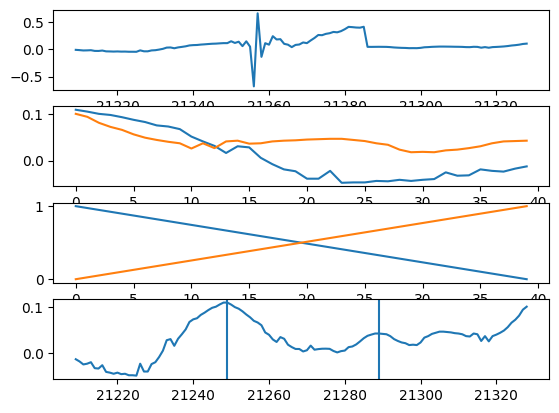

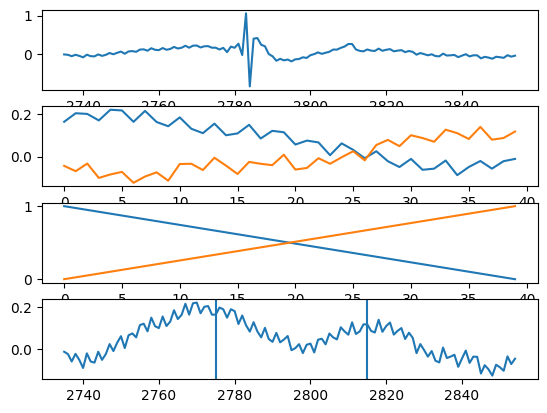

  0%|          | 0/7 [00:00<?, ?it/s]

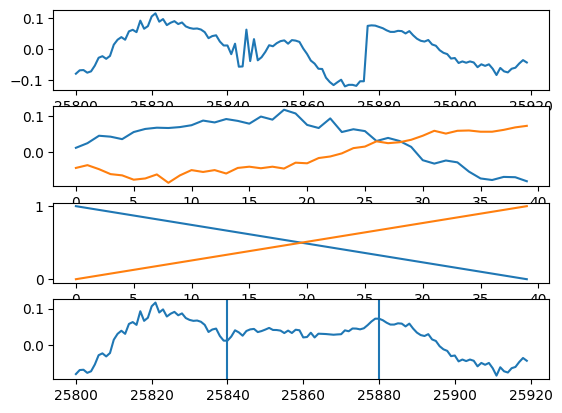

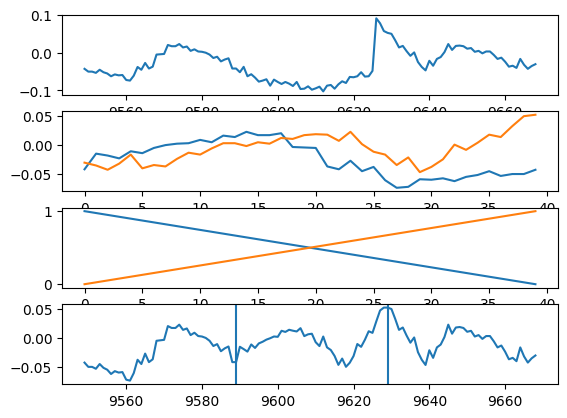

  0%|          | 0/2 [00:00<?, ?it/s]

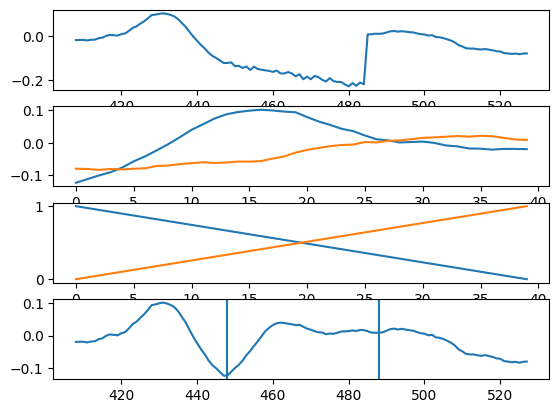

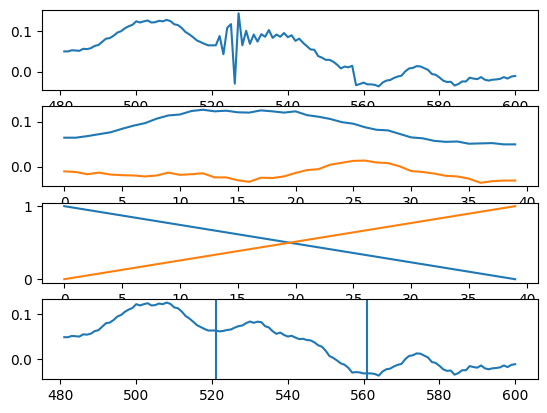

  0%|          | 0/139 [00:00<?, ?it/s]

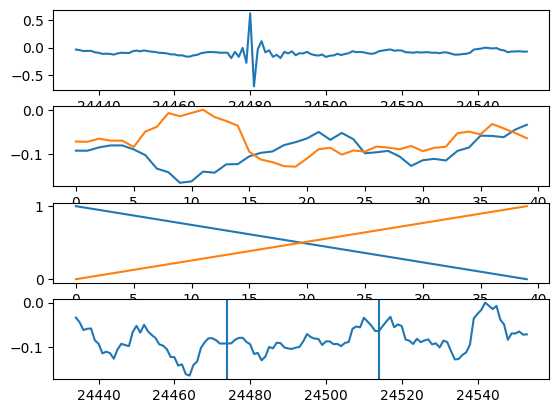

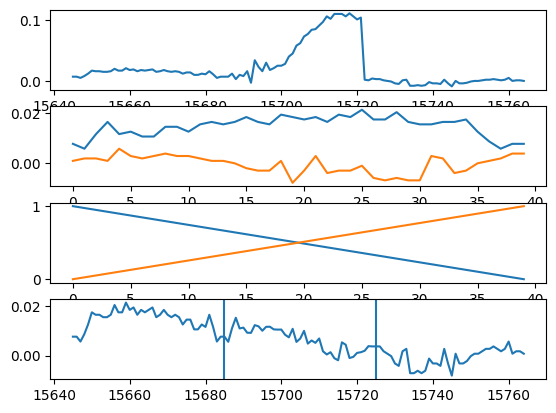

In [93]:
time_injected_effects = []
time_repaired_effects = []
freq_injected_effects = []
freq_repaired_effects = []
for pt in pt_idxs.keys():
    baseline_stds,neural_channels = get_inter_info(pt,datapath,prodatapath)
    seizure_times = seizures_df[seizures_df.Patient == pt]
    qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
    stim_sz,fs_raw,sz_row = get_sz_info(pt,0,datapath,neural_channels,seizure_times)
    spont_sz,_,_ = get_sz_info(pt,pt_idxs[pt],datapath,neural_channels,seizure_times)
    stim_ch,stim_ch_mask = get_stim_info(sz_row,stim_sz)
    threshold = baseline_stds[stim_ch_mask][1]*100
    pk_idxs = stim_detect(stim_ch,threshold,fs_raw)
    art_sz = insert_artifact(spont_sz,stim_sz,pk_idxs,fs=fs_raw)
    thresholds = baseline_stds*3
    art_chs = artifact_detect(art_sz.iloc[(pk_idxs[-1]-fs):(pk_idxs[-1]+fs),:],fs,thresholds)
   
    inj_effects = chunk_corr(stim_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,art_chs=art_chs)
    time_injected_effects.append(np.nanmean(inj_effects))
    inj_effects = chunk_corr(stim_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,freq=True,art_chs=art_chs)
    freq_injected_effects.append(np.nanmean(inj_effects))

    barn_data = barndoor(art_sz,pk_idxs,fs_raw)
    inj_effects = chunk_corr(art_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,art_chs=art_chs)
    time_repaired_effects.append(np.nanmean(inj_effects))
    inj_effects = chunk_corr(art_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,freq=True,art_chs=art_chs)
    freq_repaired_effects.append(np.nanmean(inj_effects))
    

In [94]:
time_injected_effects

[0.17296690759346406,
 0.15479442161429657,
 0.16813312172474298,
 0.09797710820119242,
 0.14452482742642178,
 0.30931516599494335,
 0.17106452354640259,
 0.2163637869532726]

MannwhitneyuResult(statistic=9.0, pvalue=0.014763014763014764)

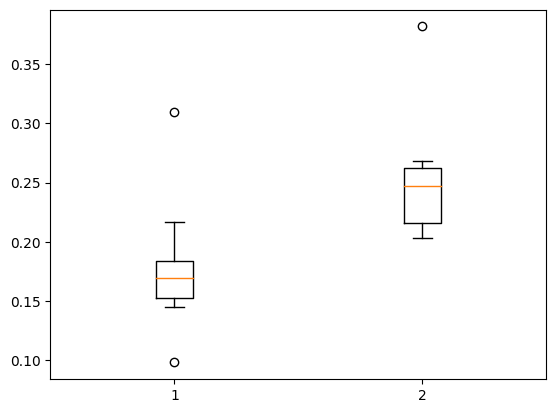

In [98]:
violin_parts = plt.boxplot((time_injected_effects,time_repaired_effects))#,showextrema=False,quantiles=[[.25,.5,.75],[.25,.5,.75]])
# pcs = violin_parts['bodies']
# pcs[0].set_facecolor('red')
# pcs[0].set_edgecolor('black')
# violin_parts['cquantiles'].set_color('black')
sc.stats.mannwhitneyu(time_injected_effects,time_repaired_effects)
plt.title()

MannwhitneyuResult(statistic=21.0, pvalue=0.2786324786324786)

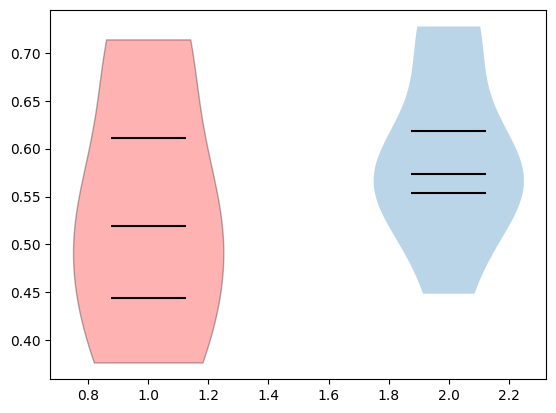

In [96]:
violin_parts = plt.violinplot((freq_injected_effects,freq_repaired_effects),showextrema=False,quantiles=[[.25,.5,.75],[.25,.5,.75]])
pcs = violin_parts['bodies']
pcs[0].set_facecolor('red')
pcs[0].set_edgecolor('black')
violin_parts['cquantiles'].set_color('black')
sc.stats.mannwhitneyu(freq_injected_effects,freq_repaired_effects)

## Seizure Preprocessing

### Metadata table

In [3]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'
len(metadata)
metadata

,index,record_id,hupsubjno,ageatieegimplant,ieeg_ictal_onset_electrodes,ieeg_ictal_onset_anat_lat,ieeg_ictal_onset_anat_spec,cceps_run1_home_meds,cceps_run1_pulsewidth,cceps_run1_sz,...,cceps_run1_soz_electrodes,cceps_run1_seizure_typical,cceps_hfs_done,cceps_hfs_seizure,cceps_hfs_stim_elec_sz,cceps_hfs_sz_typical,manual_reject_channels,final_reject_channels,ieeg_id,ccep_id
0,23,617.0,224,42.0,"RB2, RB3, RC2",2.0,hippocampus,0,300.0,1,...,"LB1, LB2, LB3, LB4, LB5, LC1, LC2, LC3, LC4, L...",2.0,2.0,2.0,NaN,NaN,NaN,"LZ06, RB10, RF06, RB05, RA10, LB08",HUP224_phaseII,HUP224_CCEP
1,24,700.0,225,33.0,"RT4, RT5",2.0,temporal neocortex,0,300.0,1,...,"RB1, RB2, RB3, RB4",1.0,1.0,2.0,NaN,NaN,"RA09, RT01","RT01, RA09",HUP225_phaseII,HUP225_CCEP
2,26,835.0,229,40.0,"LB1, LB2, LA1, LA2",1.0,mesial temporal,1,300.0,1,...,"LB1, LB2, LC1, LC2, LC3",1.0,2.0,2.0,NaN,NaN,NaN,NaN,HUP229_phaseII,HUP229_CCEP
3,27,808.0,230,51.0,"LC1, LC2, LC3, LB1, LB2",1.0,hippocampus,1,500.0,1,...,"LC1, LC2, LC3, LC4",3.0,2.0,2.0,NaN,NaN,"LB05,LB06","LB05,LB06",HUP230_phaseII,HUP230_CCEP
4,28,796.0,235,24.0,"LC1, LC2, LB2, LB3",1.0,hippocampal tail/body,1,500.0,1,...,"LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...",1.0,1.0,1.0,LA1,1.0,"LA01,LA02,LA04,LA05","LA01, LA02, LB11, LB03, LA04, LA05",HUP235_phaseII,HUP235_CCEP
5,29,861.0,238,35.0,"LB1, LB2, LB3, LC1, LC2, LC3",1.0,hippocampus,1,500.0,1,...,"LB1, LB2, LB3, LC1, LC2, LC3",1.0,1.0,2.0,NaN,NaN,"LA04,LA05,LC02,LC03,LE01,LE02,LE03,LE04,LE05,L...","LA04,LA05,LC02,LC03,LE01,LE02,LE03,LE04,LE05,L...",HUP238_phaseII,HUP238_CCEP
6,30,893.0,246,52.0,NaN,NaN,NaN,1,500.0,1,...,"LA1, LA2, LA3, LA4, LB1, LB2, LB3, LB4, LC1, L...",1.0,NaN,2.0,NaN,NaN,NaN,NaN,HUP246_phaseII,HUP246_CCEP
7,31,921.0,247,NaN,NaN,NaN,NaN,1,500.0,1,...,NaN,3.0,NaN,2.0,NaN,NaN,"RP02,RP03,RY11","RP02,RP03,RY06,RY11",HUP247_phaseII,HUP247_CCEP
8,32,876.0,249,NaN,NaN,NaN,NaN,1,500.0,1,...,RA1,2.0,NaN,2.0,NaN,NaN,"RB01,RB02","RB01,RB02",HUP249_phaseII,HUP249_CCEP
9,33,534.0,250,31.0,NaN,NaN,NaN,1,500.0,1,...,"LB1, LC1",NaN,NaN,2.0,NaN,NaN,"LB03,LB04","LO10, LZ08, LZ09, RB02, LB04, LB03, RY09",HUP250_phaseII,HUP250_CCEP


In [4]:
metadata['manual_reject_channels'].fillna("",inplace=True)
metadata['manual_reject_channels'].str.split(",")

0                                                    []
1                                         [RA09,  RT01]
2                                                    []
3                                          [LB05, LB06]
4                              [LA01, LA02, LA04, LA05]
5     [LA04, LA05, LC02, LC03, LE01, LE02, LE03, LE0...
6                                                    []
7                                    [RP02, RP03, RY11]
8                                          [RB01, RB02]
9                                          [LB03, LB04]
10                                         [RB02, RB03]
11                                   [RB02, RB03, RS08]
Name: manual_reject_channels, dtype: object

In [5]:
plt.rcParams['image.cmap'] = 'magma'
_,_,datapath,prodatapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

### CHOP localization

In [13]:
def choptimize_localizations(recon_path,chopid):
    electrode_locals = pd.read_excel(recon_path,f'{chopid}_locations')
    electrode_locals.loc[:,'name'] = clean_labels(electrode_locals.full_label,chopid)
    electrode_locals.loc[:,'index'] = pd.NA
    electrode_locals.loc[electrode_locals.brain_area == 'Unknown','brain_area'] = 'EmptyLabel'
    electrode_regions = electrode_locals.copy()
    electrode_regions["label"] = electrode_locals["brain_area"]
    col_list = ["name","x","y","z","label","isgrey"]
    electrode_regions = electrode_regions[col_list]
    mapping = {"grey": "grey matter","white": "white matter","Unknown": "EmptyLabel"}
    electrode_locals["label"] = electrode_locals["matter"].replace(mapping)
    col_list = ["name","x","y","z","label","isgrey"]
    electrode_locals = electrode_locals[col_list]
    return electrode_regions,electrode_locals


In [16]:
pt = 'CHOP005'
if pt[:3] == 'HUP':
    hup_no = pt[3:]
    rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
    rid = str(rid)
    if len(rid) < 4:
        rid = '0' + rid
    recon_path = ospj('/mnt','leif','littlab','data',
                        'Human_Data','CNT_iEEG_BIDS',
                        f'sub-RID{rid}','derivatives','ieeg_recon',
                        'module3/')
    if not os.path.exists(recon_path):
        recon_path =  ospj('/mnt','leif','littlab','data',
                        'Human_Data','recon','BIDS_penn',
                        f'sub-RID{rid}','derivatives','ieeg_recon',
                        'module3/')
    electrode_localizations,electrode_regions = optimize_localizations(recon_path,rid)
else:
    recon_path = ospj(datapath,pt,f'{pt}_locations.xlsx')
    electrode_regions,electrode_locals = choptimize_localizations(recon_path,pt)
    print(electrode_locals.head())

   name          x           y          z        label  isgrey
0  LK01  98.546875  114.695312  59.000000          CSF       3
1  LK02  95.052761  114.824724  59.156271  grey matter       1
2  LK03  91.558647  114.954136  59.312541  grey matter       1
3  LK04  88.064533  115.083547  59.468812  grey matter       1
4  LK05  84.570419  115.212959  59.625083  grey matter       1


In [7]:
temp_matter = pd.read_pickle((ospj(prodatapath,'HUP235','electrode_localizations_atropos.pkl')))
temp_region = pd.read_pickle((ospj(prodatapath,'HUP235','electrode_localizations_dkt.pkl')))
print(temp_region.head())

   name        x        y        z index            label  \
0  LA01  78.5092  138.795  134.904     0   left amygdala    
1  LA02  72.8647  138.734  133.851    18   left amygdala    
2  LA03  67.2368  138.489  133.894    18   left amygdala    
3  LA04  61.6089  138.243  133.938     0       EmptyLabel   
4  LA05  55.9644  138.182  132.885     0       EmptyLabel   

                   labels_sorted                           percent_assigned  
0  [EmptyLabel,  left amygdala ]  [0.7575757576000001, 0.24242424240000002]  
1              [ left amygdala ]                                      [1.0]  
2  [ left amygdala , EmptyLabel]               [0.8181818182, 0.1818181818]  
3                   [EmptyLabel]                                      [1.0]  
4                   [EmptyLabel]                                      [1.0]  


### Pulling patient metadata

In [5]:
def optimize_localizations(path_to_recon,RID):
    # /mnt/leif/littlab/data/Human_Data/recon/BIDS_penn/
    # python /mnt/leif/littlab/data/Human_Data/recon/code/run_penn_recons.py
    
    atropos_metadata = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    localization_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    localization_metadata = pd.read_csv(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.csv')
    def _apply_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                continue
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
        
        return x

    modified_atropos = atropos_metadata.iloc[:,:].apply(lambda x: _apply_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_metadata.columns)
    return modified_atropos_df

In [6]:
np.random.seed(42)
# Iterate through each patient
for pt in ["HUP235"]:
    print(pt)
    raw_datapath = ospj(datapath,pt)
    # load dataframe of seizure times
    seizure_times = pd.read_csv(ospj(raw_datapath,f"seizure_times_{pt}.csv"))
    # load electrode information
    # if not os.path.exists(ospj(raw_datapath, "electrode_localizations.csv")):
    hup_no = pt[3:]
    rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
    recon_path = ospj('/mnt','leif','littlab','data',
                        'Human_Data','CNT_iEEG_BIDS',
                        f'sub-RID0{rid}','derivatives','ieeg_recon',
                        'module3/')
    if not os.path.exists(recon_path):
        recon_path =  ospj('/mnt','leif','littlab','data',
                        'Human_Data','recon','BIDS_penn',
                        f'sub-RID0{rid}','derivatives','ieeg_recon',
                        'module3/')
    electrode_localizations = optimize_localizations(recon_path,rid)
    electrode_localizations.to_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    # else:    
    #     electrode_localizations = pd.read_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    ch_names = electrode_localizations[(electrode_localizations['index'] == 2) | (electrode_localizations['index'] == 3)]["name"]
    
    ch_names_clean = clean_labels(ch_names,pt)
    dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
    print(dirty_drop_electrodes)
    if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
    else:
        final_drop_electrodes = []
    ch_names_clean = [ch for ch in ch_names_clean if ch not in final_drop_electrodes]

    if not os.path.exists(ospj(raw_datapath, "seizures")):
        os.mkdir(ospj(raw_datapath, "seizures"))

HUP235
['LA01', ' LA02', ' LB11', ' LB03', ' LA04', ' LA05']


In [6]:
metadata[metadata.hupsubjno == int(pt[-3:])]

,index,Unnamed: 0.1,Unnamed: 0,record_id,hupsubjno,ageatieegimplant,ieeg_ictal_onset_electrodes,ieeg_ictal_onset_anat_lat,ieeg_ictal_onset_anat_spec,cceps_run1_home_meds,...,cceps_run1_soz_electrodes,cceps_run1_seizure_typical,cceps_hfs_done,cceps_hfs_seizure,cceps_hfs_stim_elec_sz,cceps_hfs_sz_typical,manual_reject_channels,final_reject_channels,ieeg_id,ccep_id
4,28,28,28,796.0,235,24.0,"LC1, LC2, LB2, LB3",1.0,hippocampal tail/body,1.0,...,"LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...",1.0,1.0,1.0,LA1,1.0,"LA01,LA02,LA04,LA05","LA01,LA02,LA04,LA05",HUP235_phaseII,HUP235_CCEP


In [7]:
ch_names_clean

['LA03',
 'LA06',
 'LA07',
 'LA08',
 'LA09',
 'LA10',
 'LB01',
 'LB02',
 'LB03',
 'LB04',
 'LB05',
 'LB06',
 'LB07',
 'LB08',
 'LB09',
 'LB10',
 'LB11',
 'LC01',
 'LC02',
 'LC03',
 'LC04',
 'LC05',
 'LC06',
 'LC07',
 'LC08',
 'LC09',
 'LI01',
 'LI02',
 'LI03',
 'LI04',
 'LI05',
 'LI06',
 'LI07',
 'LI08',
 'LQ01',
 'LQ02',
 'LQ03',
 'LQ04',
 'LQ05',
 'LQ06',
 'LQ07',
 'LS01',
 'LS02',
 'LS03',
 'LS04',
 'LS05',
 'LS06',
 'LS07',
 'LS08',
 'LS09',
 'LS10',
 'LS11',
 'LS12',
 'LY01',
 'LY02',
 'LY03',
 'LY04',
 'LY05',
 'LY06',
 'LY07',
 'LY08',
 'LY09',
 'LY10',
 'LZ01',
 'LZ02',
 'LZ03',
 'LZ04',
 'LZ05',
 'LZ06',
 'LZ07',
 'LZ08',
 'LZ09',
 'LZ10',
 'LZ11']

### Pulling and saving seizures

Pipeline:
Pull raw seizure (plus 15 seconds prior to seizure onset)
if not stim:
    Detect bad channels (noisy, nans, zeros)
if lfstim:
    run detect bad channels and manually parse
    use manual stim rejection channels
if hf stim:
    reject stim channel
    Detect bad channels
Store detected bad channels in master dictionary
apply notch filter
apply bandpass filter (1-200)
run artifact detection algorithm
fill in individaul channels/gaps with artifact in them
make master list for channel masking


In [21]:
# Code for within each patient's for loop
with open(passpath, "r") as f:
        pwd = f.read()
s = Session(usr, pwd)
ds = s.open_dataset(pt+"_phaseII")
all_channel_labels = ds.get_channel_labels()
# making sure all channels are in iEEG file
final_drop_electrodes += [ch for ch in ch_names_clean if ch not in all_channel_labels]
# removing any channels that don't meet criteria
ch_names_clean = [ch for ch in ch_names_clean if ch not in final_drop_electrodes]
for i_sz,row in seizure_times.iterrows():
    if i_sz != 5:
        continue
    if os.path.exists(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl")):
        buffered_seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"))
        fs = buffered_seizure.fs.to_numpy()[-1]
        cols = buffered_seizure.columns
        mask = (pd.isna(buffered_seizure.fs) | buffered_seizure.fs == 0 | np.isnan(buffered_seizure.fs))
        buffer = buffered_seizure.loc[mask,ch_names_clean]
        seizure = buffered_seizure.loc[~mask,ch_names_clean]
        t = np.arange(0,len(seizure)/fs,1/fs)
        break
    # else:
    #     seizure,fs = get_iEEG_data(usr,pass_path,
    #                                 row.IEEGname,
    #                                 row.start*1e6,
    #                                 row.end*1e6,
    #                                 ch_names_clean,
    #                                 force_pull=True)
    #     t = np.arange(0,len(seizure)/fs,1/fs)
    #     save_seizure = pd.concat((seizure,pd.DataFrame(np.ones(len(seizure),)*fs,columns=['fs'])),axis = 1)
    #     save_seizure.to_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"),index=False)
    #     break

(<Figure size 499.967x1480 with 1 Axes>, <Axes: xlabel='Time (s)'>)

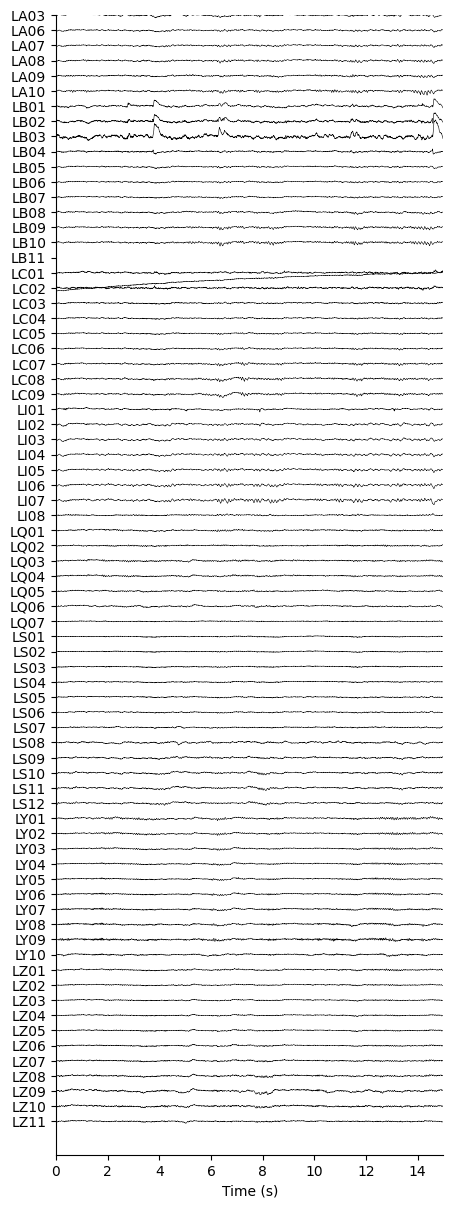

In [22]:
plot_iEEG_data(buffer,np.arange(0,len(buffer)/fs,1/fs))

(<Figure size 738.574x1480 with 1 Axes>, <Axes: xlabel='Time (s)'>)

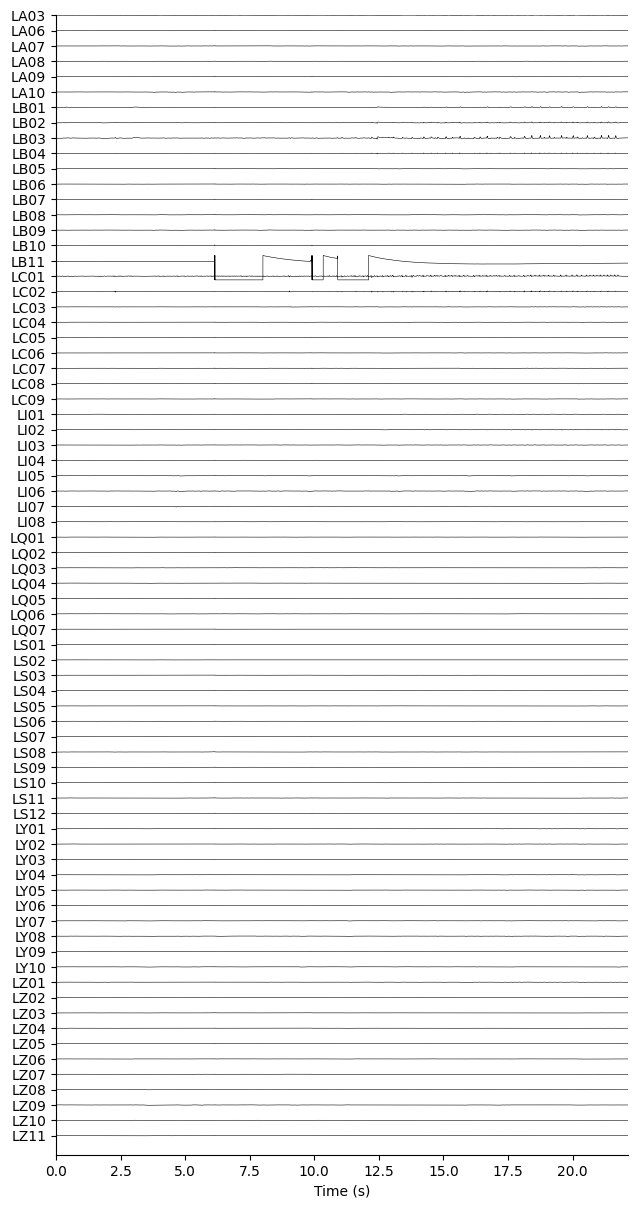

In [23]:
plot_iEEG_data(seizure,t)

### Channel Rejection

In [24]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs,True)
# want channel name associated with the 
print({key: [ch_names_clean [ch] for ch in reject_details[key]] for key in reject_details.keys()})
np.where(~reject_mask)

{'noisy': [], 'nans': [], 'zeros': [], 'flat': ['LB11'], 'var': [], 'higher_std': ['LB11'], 'high_voltage': ['LB11']}


(array([16]),)

### Filtering

In [25]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs)
reject_mask = np.ones((seizure.shape[1],),dtype=bool)

processed_seizure = seizure.loc[:,reject_mask]
reject_details

{'noisy': [],
 'nans': [],
 'zeros': [],
 'flat': [16],
 'var': [],
 'higher_std': array([16]),
 'high_voltage': [16]}

In [146]:
ch_names_rejected = list(compress(ch_names_clean,reject_mask))


In [26]:
# Here is where we need to add the mechanism to update the "total channel list" for all channels that work
# It will need to combine with the previously determined manual channels for the stim seizures
final_drop_electrodes += list(compress(ch_names_clean,~reject_mask))

In [148]:
# plot_iEEG_data(seizure.iloc[:,reject_details['high_voltage']],t)

In [149]:
# notch_seizure = notch_filter(rseizure.to_numpy(),fs)
# band_seizure = bandpass_filter(notch_seizure,fs)
# # car_seizure = band_seizure - np.mean(band_seizure, axis=0)
# processed_seizure = pd.DataFrame(band_seizure,columns=rseizure.columns)

In [150]:
# plot_iEEG_data(processed_seizure,t)

### Stim Artifact Removal

In [45]:
def artifact_removal(
    data: np.ndarray, fs: float, discon=1 / 12, noise=5000, win_size=1
) -> np.ndarray:
    """_summary_

    Args:
        data pandas
        fs (float): _description_
        discon (_type_, optional): _description_. Defaults to 1/12.
        noise (int, optional): _description_. Defaults to 15000.
        win_size (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    win_size = int(win_size * fs)
    
    n_wins = np.ceil(data.shape[0]/win_size)
    max_inds = n_wins*win_size
     
    all_inds = np.arange(max_inds)
    all_inds[data.shape[0]:] = np.nan
    ind_overlap = np.reshape(all_inds, (-1, int(win_size)))
    
    artifacts = np.empty_like(data)

    # mask indices with nan values
    artifacts = np.isnan(data)
    noisy = np.isnan(data)
    disco = np.isnan(data)

    for win_inds in ind_overlap:
        win_inds = win_inds[~np.isnan(win_inds)].astype(int)
        is_disconnected = np.sum(np.abs(data[win_inds,:]), axis=0) < discon

        is_noise = (
            np.sqrt(np.sum(np.power(np.diff(data[win_inds,:], axis=0), 2), axis=0))
            > noise
        )

        artifacts[win_inds, :] = np.logical_or(
            artifacts[win_inds, :].any(axis=0), np.logical_or(is_disconnected, is_noise)
        )
        noisy[win_inds,:] = is_noise
        disco[win_inds,:] = is_disconnected

    return artifacts,noisy,disco

In [169]:
# art_idxs,noisy,disco = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .1,
#                  noise = np.abs(np.mean(processed_seizure)) + 10*np.std(processed_seizure))
art_idxs,noisy,disco = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .1,noise=1000)

In [170]:
art_ch_reject = list(compress(ch_names_rejected,np.sum(art_idxs,axis=0)/len(art_idxs) > 0.1))
art_ch_reject

['RP01',
 'RP04',
 'RP05',
 'RP06',
 'RP07',
 'RV01',
 'RV02',
 'RV03',
 'RV04',
 'RV05',
 'RV06',
 'RV07',
 'RV08',
 'RV09',
 'RW01',
 'RW02',
 'RW03',
 'RW04',
 'RW05',
 'RW06',
 'RW07',
 'RX01',
 'RX02',
 'RX03',
 'RX04',
 'RX05',
 'RX06',
 'RX07',
 'RX08',
 'RX09',
 'RX10',
 'RX11',
 'RX12',
 'RY01',
 'RY02',
 'RY03',
 'RY04',
 'RY05',
 'RY07']

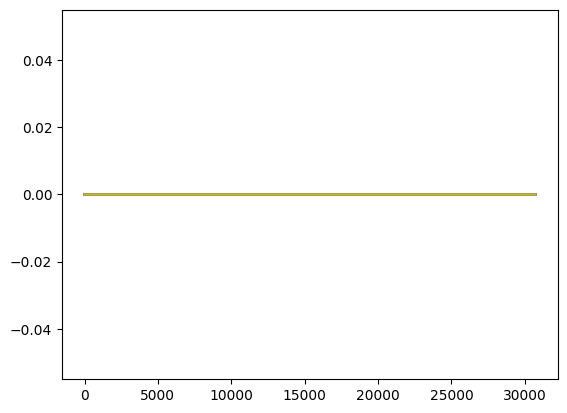

In [172]:
plt.plot(noisy);

In [155]:
# artifact_mask = sig.medfilt(art_idxs.astype(int),(3,1))
# stim_idxs = [np.reshape(np.where(np.diff(artifact_mask[:,ch],prepend=0)),(-1,2))for ch in range(art_idxs.shape[1])]
artifact_mask = sig.medfilt(art_idxs.any(1).astype(int),5)
stim_idxs = np.reshape(np.where(np.diff(artifact_mask,prepend=0)),(-1,2))
s = processed_seizure.copy().to_numpy()



ValueError: cannot reshape array of size 1 into shape (2)

In [118]:
np.random.seed(42)
for i_ch in range(sum(reject_mask)):
    for win in stim_idxs:
        win_len = win[1]-win[0]
        pre_idx = win[0] - win_len
        post_idx = win[1] + win_len
        if post_idx > len(s):
            post_idx = win[1]
        # Plotting raw signal
        # plot_seg = processed_seizure.iloc[pre_idx:post_idx,i_ch].to_numpy()
        # plt.figure()
        # plt.plot(t[np.arange(pre_idx,post_idx)],plot_seg)
        # plt.vlines([(win_len + pre_idx)/fs, (2*win_len+pre_idx)/fs],plot_seg.min(),plot_seg.max())

        # Interpolation parameters
        pre_idxs = np.arange(pre_idx,win[0])
        post_idxs = np.arange(win[1],post_idx)
        fill_idxs = np.arange(win[0],win[1])

        # Interpolation
        # check for edge cases
        if win[0] < win_len:
            pre_t = np.arange((pre_idx)/fs,(win[0])/fs,1/fs)
            post_t = t[post_idxs]
            pre_win = buffer.loc[:,ch_names_clean[i_ch]].to_numpy()[pre_idxs]
            post_win = s[post_idxs,i_ch]

        elif post_idx > len(s):
            pre_win = s[pre_idxs,i_ch]
            pre_t = t[pre_idxs]
            post_win = pre_win
            post_t = pre_t
        else:
            pre_win = s[pre_idxs,i_ch]
            pre_t = t[pre_idxs]
            post_win = s[post_idxs,i_ch]
            post_t = t[post_idxs]
        interp_fn = sc.interpolate.interp1d(np.concatenate([pre_t,t[post_idxs]]),
                                np.concatenate([pre_win,post_win]))
        # run interpolation
        filled_s = interp_fn(t[fill_idxs])

        # Adding noise to interpolation
        sample_std = (np.std(pre_win) + np.std(s[post_idxs,i_ch]))/8
        
        interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

        # # # Plotting interpolation
        # plt.figure()
        # plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],filled_s,color='r')
        # plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')
        
        s[win[0]:win[1],i_ch] = interp_samples

ValueError: A value (36.556640625) in x_new is above the interpolation range's maximum value (36.5556640625).

In [30]:
# cols = ch_names_clean
# cols.append('fs')
# postrejection_seizure = pd.DataFrame(np.concatenate((s,np.ones((len(s,),1))*fs),axis=1), columns = cols)

In [31]:
# postrejection_seizure.head()

In [32]:
# plot_iEEG_data(s,t)

In [33]:
notch_seizure = notch_filter(s,fs)
band_seizure = bandpass_filter(notch_seizure,fs)
car_seizure = band_seizure - np.mean(band_seizure, axis=0)
filtered_seizure = pd.DataFrame(car_seizure,columns=processed_seizure.columns)

ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [34]:
plot_iEEG_data(filtered_seizure,t)

NameError: name 'filtered_seizure' is not defined